In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Load datasets
batch_size = 32
img_height = 224
img_width = 224

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

# Retrieve class names
class_names = train_dataset.class_names

# Prefetch the data for optimal performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Define the preprocessing function
def preprocess(image, label):
    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # image = tf.image.random_zoom(image, [0.9, 1.1], [0.9, 1.1])
    image = tf.image.random_crop(image, size=[img_height, img_width, 3])
    # Normalize the images to the range the pre-trained model expects
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Create the base model from the pre-trained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Define the number of classes
num_classes = len(class_names)  # Set the number of classes here

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
epochs = 30  # Keeping a higher number of epochs with early stopping
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
print(f'Test accuracy: {accuracy}')


Found 800 files belonging to 20 classes.
Found 200 files belonging to 20 classes.
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.3227 - loss: 2.3953 - val_accuracy: 0.8000 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.8960 - loss: 0.4105 - val_accuracy: 0.8400 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9614 - loss: 0.1325 - val_accuracy: 0.9450 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - accuracy: 0.9908 - loss: 0.0607 - val_accuracy: 0.9400 - val_loss: 0.1989 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.9871 - loss: 0.0551 - val_accuracy: 0.9350 - val_loss: 0.2363 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.9882 - loss: 0.0463 - val_accuracy: 0.9550 - val_loss: 0.1696 - learning_rate: 0.0010
Epoch

In [7]:
train_loss = history.history['loss'][-1]
train_acc = history.history['accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

print(f"Test Loss: {val_loss:.4f}")
print(f"Test Accuracy: {val_acc:.4f}")

print(f'Test loss: {loss:.4f}')

Train Loss: 0.0237
Train Accuracy: 0.9950
Validation Loss: 0.2326
Validation Accuracy: 0.9350
Test loss: 0.1696


In [4]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,749,889 (33.38 MB)

 Trainable params: 2,017,092 (7.69 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 4,034,186 (15.39 MB)

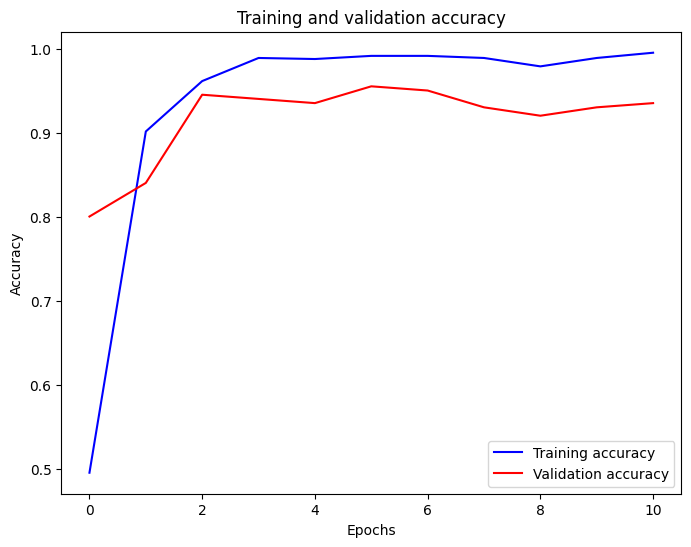

In [3]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite and saved as 'model.tflite'")

# Convert model to .h5
model.save('model3.h5')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('model3.h5')

# Define function to preprocess an image file for prediction
def preprocess_image(file_path):
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Example usage: Predicting on a single image
image_path = 'dataset/uji/rawon2.jpg'
preprocessed_img = preprocess_image(image_path)
predictions = model.predict(preprocessed_img)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Retrieve class labels
class_names_file = 'labels.txt'
with open(class_names_file, 'r') as f:
    class_names = f.read().splitlines()

# Print results
print(f'Predicted class: {class_names[predicted_class]}')
print(f'Confidence: {confidence:.2f}')

1/1 [==============================] - 1s 836ms/step
Predicted class: Rawon: 400-500 kalori
Confidence: 1.00
